# Author: Tobias

In [2]:
import os 
import datetime
from pathlib import Path
from dotenv import load_dotenv, find_dotenv

basepath = Path(os.getcwd())
# make sure your working directory is the repository root.
if basepath.name != "idp-radio-1":
    os.chdir(basepath.parent.parent.parent)
load_dotenv(find_dotenv())

%load_ext autoreload
%autoreload 2
os.getcwd()

import os 
import tensorflow as tf
from pathlib import Path
import cv2

# Run this before loading other dependencies, otherwise they might occupy memory on gpu 0 by default and it will stay that way

# Specify which GPU(s) to use
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Or 2, 3, etc. other than 0

config = tf.compat.v1.ConfigProto(device_count={'GPU': 0}, allow_soft_placement=True, log_device_placement=True)
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 1.0
tf.compat.v1.Session(config=config)

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.resnet_v2 import ResNet101V2
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from src.architectures.simple.simple_base import SimpleBaseArchitecture
import numpy as np

from src.architectures.benchmarks.benchmark import Benchmark, Experiment
from tensorflow.keras.optimizers import Adam, SGD
from src.architectures.simple.load_model import *
from src.architectures.benchmarks.benchmark_definitions import Chexpert_Benchmark, Chestxray14_Benchmark, simple_architecture_experiment, generate_benchmarks, METRICS, SINGLE_CLASS_METRICS, CHEXPERT_COLUMNS, CHESTXRAY14_COLUMNS
from src.metrics.metrics import F2Score
from src.metrics.losses import WeightedBinaryCrossentropy, BinaryCrossentropy, compute_class_weight
from src.utils.save_model import load_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



In [7]:
# color, affine + color, affine
#model_ids = ["c55ed5c6-e879-11ea-9a58-0242ac110005", "2eb47be0-e88c-11ea-9a58-0242ac110005", "74d8220a-e6c2-11ea-b084-0242ac110005"]

experiment_ids = ["f5345e7e-e603-11ea-b461-0242ac110005",
             "74d8220a-e6c2-11ea-b084-0242ac110005",
             #"7f0b1972-e5e5-11ea-a85b-0242ac110005",
             #"ba5364e6-e949-11ea-87eb-0242ac110005",
             "bd5c2e9a-e9ec-11ea-ae3a-0242ac110005"
]

experiment_ids = [
    "bd5c2e9a-e9ec-11ea-ae3a-0242ac110005",
    "bca75ad8-e6f4-11ea-a90b-0242ac110005",
    "74d8220a-e6c2-11ea-b084-0242ac110005",
    "e506d8f0-ea0f-11ea-8dbb-0242ac110005",
    "67131280-e7d8-11ea-b8fe-0242ac110005",
    "5dcb7ecc-e4e2-11ea-96c6-0242ac110005",
    "2eb47be0-e88c-11ea-9a58-0242ac110005",
    "7f0b1972-e5e5-11ea-a85b-0242ac110005",
]

experiment_ids = [
    "1a955742-e3ff-11ea-bd3d-0242ac110005",
    "541ed996-e410-11ea-a602-0242ac110005",
    "1262eecc-e490-11ea-a3de-0242ac110005",
    "5663f98e-e44c-11ea-bed5-0242ac110005",
]


# reevaluated valid auc: best models per class 
experiment_ids = ['b57e5750-e66a-11ea-bb5e-0242ac110005',
  '74d8220a-e6c2-11ea-b084-0242ac110005',
  'e506d8f0-ea0f-11ea-8dbb-0242ac110005',
  '5dcb7ecc-e4e2-11ea-96c6-0242ac110005',
  'bd5c2e9a-e9ec-11ea-ae3a-0242ac110005',
  '7f0b1972-e5e5-11ea-a85b-0242ac110005',
  'ef363064-e53c-11ea-8173-0242ac110005']

# reevaluated test auc: best models per class 
experiment_ids = ['1262eecc-e490-11ea-a3de-0242ac110005',
  '4267e786-e2dc-11ea-a072-0242ac110005',
  'f5345e7e-e603-11ea-b461-0242ac110005',
  'fc098932-e58f-11ea-8d19-0242ac110005',
  'ac1da21e-e47c-11ea-ad88-0242ac110005',
  'a99f1906-e4a3-11ea-87a3-0242ac110005',
  'ba5364e6-e949-11ea-87eb-0242ac110005',
  'conf-c55ed5c6-e879-11ea-9a58-0242ac110005',
  'bd5c2e9a-e9ec-11ea-ae3a-0242ac110005']

experiment_names = [
    "InceptionResNetV2_Chexpert_BCE_NoNorm_E5_B32_C0_N12_AugAffine_sharp21_U75_D256_DS9505_1LR4_LF1_Adam_Upsampled",
    "Xception-2_Chexpert_BCE_NoNorm_E5_B32_C0_N12_AugAffine_sharp21_U75_D256_DS9505_1LR4_LF1_Adam_Upsampled",
    "DenseNet121_Chexpert_BCE_NoNorm_E5_B32_C0_N12_AugAffine_sharp21_U75_D256_DS9505_1LR4_LF1_Adam_Upsampled",
    "DenseNet169_Chexpert_CWBCE_L1Normed_E5_B32_C0_N12_AugAffine_sharp21_U75_D256_DS9505_1LR4_LF1_Adam_Upsampled",
]

#ensemble auc 0.88
experiment_ids = [
    "1a955742-e3ff-11ea-bd3d-0242ac110005",
    "541ed996-e410-11ea-a602-0242ac110005",
    "1262eecc-e490-11ea-a3de-0242ac110005",
    "5663f98e-e44c-11ea-bed5-0242ac110005",
]

experiment_ids = [
    "1a955742-e3ff-11ea-bd3d-0242ac110005",
    "541ed996-e410-11ea-a602-0242ac110005",
    "1262eecc-e490-11ea-a3de-0242ac110005",
    #"5663f98e-e44c-11ea-bed5-0242ac110005",
    
    #"c2a1ebe2-e3ca-11ea-b11d-0242ac110005",
    #"33836220-e216-11ea-bf5d-0242ac110005",
    #"20782b86-e2c3-11ea-b42f-0242ac110005",
    #"4267e786-e2dc-11ea-a072-0242ac110005",
]


experiment_ids = [
    "1a955742-e3ff-11ea-bd3d-0242ac110005",
    "03479e56-ee90-11ea-b021-0242ac110002",
    "3690b8d6-eeab-11ea-8206-0242ac110002",
]
experiment_names = [
    "DenseNet121_2_Chexpert_CWBCE_L1Normed_E5_B32_C0_N12_AugAffine_sharp21_U75_D256_DS9505_1LR4_LF1_Adam_Upsampled",
    "InceptionResNetV2_Chexpert_BCE_NoNorm_E5_B32_C0_N12_AugAffine_sharp21_U75_D256_DS9505_1LR4_LF1_Adam_Upsampled",
    "DenseNet121_Chexpert_WBCE_E3_B32_C0_N12_AugAffine_U75_D256_DS9505_1LR1_LF5_SGD_Upsampled",
]

experiment_ids = [('bd5c2e9a-e9ec-11ea-ae3a-0242ac110005', 3, 0.8613448359749534),
                 ('bd5c2e9a-e9ec-11ea-ae3a-0242ac110005', 4, 0.8604057214476846),
                 ('bd5c2e9a-e9ec-11ea-ae3a-0242ac110005', 5, 0.8603749329393561),
                 ('bd5c2e9a-e9ec-11ea-ae3a-0242ac110005', 2, 0.86009220643477),
                 ('bca75ad8-e6f4-11ea-a90b-0242ac110005', 2, 0.8534599163315513),
                 ('bca75ad8-e6f4-11ea-a90b-0242ac110005', 4, 0.8475377505475824),
                 ('74d8220a-e6c2-11ea-b084-0242ac110005', 2, 0.8475213592702692),
                 ('bca75ad8-e6f4-11ea-a90b-0242ac110005', 5, 0.8474861112507907),
                 ('1262eecc-e490-11ea-a3de-0242ac110005', 3, 0.8471921357241544),
                 ('bca75ad8-e6f4-11ea-a90b-0242ac110005', 3, 0.8467668078162454),
                 ('74d8220a-e6c2-11ea-b084-0242ac110005', 1, 0.8463928970423612)]
experiment_names = [
    "InceptionResNetV2_Chexpert_BCE_NoNorm_E5_B32_C0_N12_AugAffine_sharp21_U75_D256_DS9505_1LR4_LF1_Adam_Upsampled",
    "Xception-2_Chexpert_BCE_NoNorm_E5_B32_C0_N12_AugAffine_sharp21_U75_D256_DS9505_1LR4_LF1_Adam_Upsampled",
    "DenseNet121_Chexpert_BCE_NoNorm_E5_B32_C0_N12_AugAffine_sharp21_U75_D256_DS9505_1LR4_LF1_Adam_Upsampled",
    "DenseNet169_Chexpert_CWBCE_L1Normed_E5_B32_C0_N12_AugAffine_sharp21_U75_D256_DS9505_1LR4_LF1_Adam_Upsampled",
]
# best classbased test auc
experiment_ids = ['1262eecc-e490-11ea-a3de-0242ac110005',
  '4267e786-e2dc-11ea-a072-0242ac110005',
  '03479e56-ee90-11ea-b021-0242ac110002',
  'fc098932-e58f-11ea-8d19-0242ac110005',
  'ac1da21e-e47c-11ea-ad88-0242ac110005',
  'a99f1906-e4a3-11ea-87a3-0242ac110005',
  'ba5364e6-e949-11ea-87eb-0242ac110005',
  'conf-c55ed5c6-e879-11ea-9a58-0242ac110005',
  'f5345e7e-e603-11ea-b461-0242ac110005',
  '653d264a-ee44-11ea-bcb1-0242ac110002']

#ensemble auc 0.88
experiment_ids = [
    "1a955742-e3ff-11ea-bd3d-0242ac110005",
    "541ed996-e410-11ea-a602-0242ac110005",
    "1262eecc-e490-11ea-a3de-0242ac110005",
    "5663f98e-e44c-11ea-bed5-0242ac110005",
]


In [6]:
experiments = {} 
experiment_dicts = {} 
for experiment_name in experiment_names:
    exp_dict = get_experiment_from_logs(name=experiment_name)
    experiment = rebuild_experiment(exp_dict)
    exp_dict["test_again"] = reevaluate(experiment)
    exp_dict["test_difference"] = sum(difference_test_results(exp_dict["test"], exp_dict["test_again"]).values())
    print("test_difference is ", exp_dict["test_difference"])
    experiment_dicts[exp_dict["name"]] = exp_dict
    experiments[exp_dict["name"]] =  experiment
        
experiments

Using weights file InceptionResNetV2_Chexpert_BCE_NoNorm_E5_B32_C0_N12_AugAffine_sharp21_U75_D256_DS9505_1LR4_LF1_Adam_Upsampled_20200825-170219.h5 to load model...


KeyboardInterrupt: 

In [8]:
experiments = {} 
experiment_dicts = {} 
for experiment_id in experiment_ids:
    exp_dict = get_experiment_from_logs(experiment_id=experiment_id)
    experiment = rebuild_experiment(exp_dict)
    exp_dict["test_again"] = reevaluate(experiment, new_metrics=True)
    exp_dict["test_difference"] = sum(difference_test_results(exp_dict["test"], exp_dict["test_again"]).values())
    print("test_difference is ", exp_dict["test_difference"])
    experiment_dicts[exp_dict["name"]] = exp_dict
    experiments[exp_dict["name"]] =  experiment
        
experiments

Using weights file DenseNet121_Chexpert_BCE_E3_B32_C0_N12_Uones_D256_DS9505_2LR1_LF5_SGD_Upsampled_1_20200821-223859.h5 to load model...
234/234 [==============================] - 5s 21ms/step
test_difference is  5.960464477539063e-08
Using weights file DenseNet121_Chexpert_BCE_E3_B32_C0_N12_AugAffine_Uones_D256_DS9505_2LR1_LF5_SGD_Upsampled_1_20200822-004217.h5 to load model...
234/234 [==============================] - 5s 21ms/step
test_difference is  1.7881393432617188e-07
Using weights file DenseNet121_Chexpert_WBCE_E3_B32_C0_N12_AugAffine_U75_D256_DS9505_1LR1_LF5_SGD_Upsampled_20200822-155642.h5 to load model...
234/234 [==============================] - 5s 20ms/step
test_difference is  1.1920928955078125e-07
Using weights file DenseNet121_Chexpert_BCE_E3_B32_C0_N12_AugAffine_U66_D256_DS9505_2LR1_LF5_SGD_Upsampled_1_20200822-075150.h5 to load model...
234/234 [==============================] - 4s 19ms/step
test_difference is  1.1920928955078125e-07


{'DenseNet121_Chexpert_BCE_E3_B32_C0_N12_Uones_D256_DS9505_2LR1_LF5_SGD_Upsampled_1': <src.architectures.benchmarks.benchmark.Experiment at 0x7ff733618048>,
 'DenseNet121_Chexpert_BCE_E3_B32_C0_N12_AugAffine_Uones_D256_DS9505_2LR1_LF5_SGD_Upsampled_1': <src.architectures.benchmarks.benchmark.Experiment at 0x7ff47018c4a8>,
 'DenseNet121_Chexpert_WBCE_E3_B32_C0_N12_AugAffine_U75_D256_DS9505_1LR1_LF5_SGD_Upsampled': <src.architectures.benchmarks.benchmark.Experiment at 0x7ff15d09e518>,
 'DenseNet121_Chexpert_BCE_E3_B32_C0_N12_AugAffine_U66_D256_DS9505_2LR1_LF5_SGD_Upsampled_1': <src.architectures.benchmarks.benchmark.Experiment at 0x7ff129a01d30>}

In [ ]:
experiments = [] 
experiment_dicts = []
for experiment_id, epoch, _ in experiment_ids:
    exp_dict = get_experiment_from_logs(experiment_id=experiment_id)
    experiment = rebuild_experiment(exp_dict, epoch=epoch)
    exp_dict["test_again"] = reevaluate(experiment, new_metrics=True)
    exp_dict["test_difference"] = sum(difference_test_results(exp_dict["test"], exp_dict["test_again"]).values())
    print("test_difference is ", exp_dict["test_difference"])
    experiment_dicts.append(exp_dict)
    experiments.append(experiment)
        
experiments

In [9]:
[{"id":exp_dict["id"], "auc1": exp_dict["test"]["auc"],"auc2": exp_dict["test_again"]["auc"], "diff": exp_dict["test_difference"]} for exp_dict in experiment_dicts.values()]

[{'id': '1a955742-e3ff-11ea-bd3d-0242ac110005',
  'auc1': 0.7546828389167786,
  'auc2': 0.75468284,
  'diff': 5.960464477539063e-08},
 {'id': '541ed996-e410-11ea-a602-0242ac110005',
  'auc1': 0.7180982232093811,
  'auc2': 0.7180982,
  'diff': 1.7881393432617188e-07},
 {'id': '1262eecc-e490-11ea-a3de-0242ac110005',
  'auc1': 0.7765927314758301,
  'auc2': 0.77659273,
  'diff': 1.1920928955078125e-07},
 {'id': '5663f98e-e44c-11ea-bed5-0242ac110005',
  'auc1': 0.7743986248970032,
  'auc2': 0.7743986,
  'diff': 1.1920928955078125e-07}]

In [ ]:
#experiment_dicts["DenseNet121_Chexpert_CWBCE_L1Normed_E5_B32_C0_N12_AugAffine_sharp21_U75_D256_DS9505_1LR4_LF1_Adam_Upsampled"]["benchmark"]

In [ ]:
#experiments["DenseNet121_Chexpert_CWBCE_L1Normed_E5_B32_C0_N12_AugAffine_sharp21_U75_D256_DS9505_1LR4_LF1_Adam_Upsampled"].benchmark.as_dict()

In [ ]:
#experiment_dicts["DenseNet121_Chexpert_CWBCE_L1Normed_E5_B32_C0_N12_AugAffine_sharp21_U75_D256_DS9505_1LR4_LF1_Adam_Upsampled"]["test"]

In [32]:
experiment_ids[0][1]

3

In [ ]:
#benchmark.valgen.classes = benchmark.valgen.get_labels()
#benchmark.testgen.classes = benchmark.testgen.get_labels()
#benchmark.valgen.n = len(benchmark.valgen) * benchmark.valgen.batch_size - 1
#benchmark.testgen.n = len(benchmark.testgen) * benchmark.testgen.batch_size - 1

In [4]:
#!pip install deepstack

In [10]:
from deepstack.base import KerasMember

keras_member = []
if isinstance(experiments, dict):
    for name, exp in experiments.items():
        keras_member.append(KerasMember(name=name, keras_model=exp.model, train_batches=exp.benchmark.valgen, val_batches=exp.benchmark.testgen))
elif isinstance(experiments, list):
    for index, exp in enumerate(experiments):
        keras_member.append(KerasMember(name=exp.model_name + "_" + str(experiment_ids[index][1]), keras_model=exp.model, train_batches=exp.benchmark.valgen, val_batches=exp.benchmark.testgen))



Instructions for updating:
Please use Model.predict, which supports generators.
234/234 [==============================] - 4s 19ms/step


In [11]:
keras_member

[<Member: DenseNet121_Chexpert_BCE_E3_B32_C0_N12_Uones_D256_DS9505_2LR1_LF5_SGD_Upsampled_1>,
 <Member: DenseNet121_Chexpert_BCE_E3_B32_C0_N12_AugAffine_Uones_D256_DS9505_2LR1_LF5_SGD_Upsampled_1>,
 <Member: DenseNet121_Chexpert_WBCE_E3_B32_C0_N12_AugAffine_U75_D256_DS9505_1LR1_LF5_SGD_Upsampled>,
 <Member: DenseNet121_Chexpert_BCE_E3_B32_C0_N12_AugAffine_U66_D256_DS9505_2LR1_LF5_SGD_Upsampled_1>]

In [10]:

reference_classes = keras_member[0].train_classes
for member in keras_member:
    if not np.array_equal(member.train_classes, reference_classes):
        member.train_classes = reference_classes

In [3]:
def auc_metric(y_true, y_pred):
    m = tf.keras.metrics.AUC(multi_label = True)
    m.reset_states()
    m.update_state(y_true, y_pred)
    return m.result().numpy()

In [4]:
def get_auc_metric(exp):
    def auc_metric(y_true, y_pred):
        m = [m for m in exp.benchmark.metrics if m.name=="auc"][0]
        m.reset_states()
        m.update_state(tf.constant(y_true), tf.constant(y_pred))
        return m.result().numpy()
    return auc_metric

In [13]:
from deepstack.ensemble import DirichletEnsemble

defaultN = 10000
wAvgEnsemble = DirichletEnsemble(N=defaultN*1, metric=auc_metric)
wAvgEnsemble.add_members(keras_member)
wAvgEnsemble.fit()
wAvgEnsemble.describe()

DenseNet121_Chexpert_BCE_E3_B32_C0_N12_Uones_D256_DS9505_2LR1_LF5_SGD_Upsampled_1 - Weight: 0.0514 - auc_metric: 0.7547
DenseNet121_Chexpert_BCE_E3_B32_C0_N12_AugAffine_Uones_D256_DS9505_2LR1_LF5_SGD_Upsampled_1 - Weight: 0.0004 - auc_metric: 0.7181
DenseNet121_Chexpert_WBCE_E3_B32_C0_N12_AugAffine_U75_D256_DS9505_1LR1_LF5_SGD_Upsampled - Weight: 0.6872 - auc_metric: 0.7766
DenseNet121_Chexpert_BCE_E3_B32_C0_N12_AugAffine_U66_D256_DS9505_2LR1_LF5_SGD_Upsampled_1 - Weight: 0.2611 - auc_metric: 0.7744
DirichletEnsemble auc_metric: 0.7824


In [14]:
wAvgEnsemble.bestweights

array([5.13637491e-02, 3.59683030e-04, 6.87150217e-01, 2.61126351e-01])

In [15]:

#wAvgEnsemble.describe()

In [26]:
from deepstack.ensemble import StackEnsemble
from sklearn.ensemble import *

from sklearn.neural_network import *
from sklearn.tree import *

from sklearn.metrics import accuracy_score

stack = StackEnsemble()

stack.model = RandomForestRegressor(verbose=1, n_estimators=2000, max_depth=10, n_jobs=20, min_samples_split=5)
#stack.model = DecisionTreeClassifier(max_depth=100,  min_samples_split=2)
stack.model = MLPClassifier(verbose=1,hidden_layer_sizes=(50, 20), learning_rate_init=0.001, max_iter=2000)

stack.add_members(keras_member)
stack.fit()
stack.describe(metric=auc_metric)

Iteration 1, loss = 7.54011781
Iteration 2, loss = 5.66447464
Iteration 3, loss = 4.76053516
Iteration 4, loss = 4.50915675
Iteration 5, loss = 4.37806733
Iteration 6, loss = 4.29368889
Iteration 7, loss = 4.23545626
Iteration 8, loss = 4.18894180
Iteration 9, loss = 4.15641463
Iteration 10, loss = 4.13484466
Iteration 11, loss = 4.12002970
Iteration 12, loss = 4.10991270
Iteration 13, loss = 4.10172510
Iteration 14, loss = 4.09490461
Iteration 15, loss = 4.08913005
Iteration 16, loss = 4.08356035
Iteration 17, loss = 4.07979218
Iteration 18, loss = 4.07672338
Iteration 19, loss = 4.07270081
Iteration 20, loss = 4.06940069
Iteration 21, loss = 4.06593004
Iteration 22, loss = 4.06309221
Iteration 23, loss = 4.06091876
Iteration 24, loss = 4.06016103
Iteration 25, loss = 4.05687179
Iteration 26, loss = 4.05468627
Iteration 27, loss = 4.05250711
Iteration 28, loss = 4.04921154
Iteration 29, loss = 4.04957546
Iteration 30, loss = 4.04701757
Iteration 31, loss = 4.04674107
Iteration 32, los

0.6907604

In [10]:
assert all([(np.array_equal(keras_member[i].train_classes,
                              keras_member[i + 1].train_classes))
              for i in range(len(keras_member) - 1)])


training_data_x = np.concatenate(tuple([member.train_probs for member in keras_member]), axis=1)
training_data_y = keras_member[0].train_classes

validation_data_x = np.concatenate(tuple([member.val_probs for member in keras_member]), axis=1)
validation_data_y = keras_member[0].val_classes


In [11]:
assert len(training_data_x) == len(training_data_y)
assert training_data_x.shape[1] == training_data_y.shape[1] * len(keras_member)
input_size = training_data_x.shape[1] 
output_size = training_data_y.shape[1] #this is number of classes

In [12]:
meta_learner = tf.keras.Sequential()
meta_learner.add(tf.keras.Input(shape=(input_size,)))
#meta_learner.add(tf.keras.layers.Dense(36))
meta_learner.add(tf.keras.layers.Dense(output_size,
                                       activation='sigmoid',
                                       #kernel_regularizer=tf.keras.regularizers.L2(0.01)
                                      )
                )
meta_learner.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 12)                588       
Total params: 588
Trainable params: 588
Non-trainable params: 0
_________________________________________________________________


In [13]:
lr_schedul = tf.keras.optimizers.schedules.ExponentialDecay(1e-3,
                                                            decay_steps=1850,
                                                            decay_rate=0.99, 
                                                            staircase=True)

optim = tf.keras.optimizers.Adam(learning_rate=lr_schedul)

meta_learner.compile(optimizer=optim,
                     loss=tf.keras.losses.BinaryCrossentropy(),
                     metrics=[tf.keras.metrics.AUC(name="auc", multi_label = True)])

train_results = meta_learner.fit(x=training_data_x,
                                 y=training_data_y,
                                 validation_data=(validation_data_x, validation_data_y),
                                 batch_size=32,
                                 epochs=100,
                                 shuffle=True)

Epoch 1/100
363/363 [==============================] - 2s 6ms/step - loss: 0.4949 - auc: 0.5642 - val_loss: 0.4867 - val_auc: 0.4369
Epoch 2/100
363/363 [==============================] - 2s 5ms/step - loss: 0.3751 - auc: 0.6057 - val_loss: 0.4571 - val_auc: 0.4744
Epoch 3/100
363/363 [==============================] - 2s 5ms/step - loss: 0.3507 - auc: 0.6329 - val_loss: 0.4437 - val_auc: 0.5092
Epoch 4/100
363/363 [==============================] - 2s 6ms/step - loss: 0.3390 - auc: 0.6536 - val_loss: 0.4328 - val_auc: 0.5409
Epoch 5/100
363/363 [==============================] - 2s 5ms/step - loss: 0.3316 - auc: 0.6716 - val_loss: 0.4250 - val_auc: 0.5755
Epoch 6/100
363/363 [==============================] - 2s 5ms/step - loss: 0.3263 - auc: 0.6862 - val_loss: 0.4176 - val_auc: 0.5940
Epoch 7/100
363/363 [==============================] - 2s 5ms/step - loss: 0.3224 - auc: 0.6983 - val_loss: 0.4122 - val_auc: 0.6105
Epoch 8/100
363/363 [==============================] - 2s 5ms/step - 

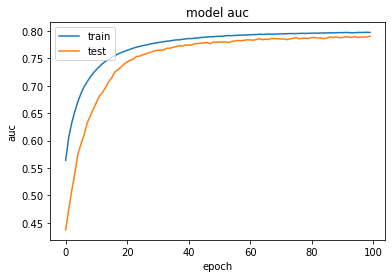

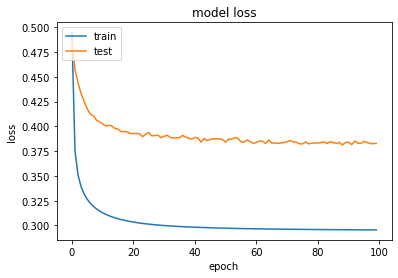

In [14]:
import matplotlib.pyplot as plt
plt.plot(train_results.history['auc'])
plt.plot(train_results.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(train_results.history['loss'])
plt.plot(train_results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
meta_predictions_test = meta_learner.predict(validation_data_x)

In [18]:
meta_test_metrics = calc_metrics(validation_data_y, meta_predictions_test, exp.benchmark.metrics)
np.array([v for k, v in meta_test_metrics.items() if k.startswith("auc_")][:-1]).mean() , meta_test_metrics

(0.86222416,
 {'auc': 0.79037213,
  'precision': 0.8377193,
  'recall': 0.34981686,
  'f2_score': 0.395937,
  'binary_accuracy': 0.8603988,
  'accuracy_enlarged_cardiomediastinum': 0.53846157,
  'accuracy_cardiomegaly': 0.73504275,
  'accuracy_lung_opacity': 0.7948718,
  'accuracy_lung_lesion': 0.99572647,
  'accuracy_edema': 0.9059829,
  'accuracy_consolidation': 0.85897434,
  'accuracy_pneumonia': 0.95726496,
  'accuracy_atelectasis': 0.7222222,
  'accuracy_pneumothorax': 0.96153843,
  'accuracy_pleural_effusion': 0.8717949,
  'accuracy_pleural_other': 0.991453,
  'accuracy_fracture': 0.991453,
  'auc_enlarged_cardiomediastinum': 0.50183487,
  'auc_cardiomegaly': 0.7859231,
  'auc_lung_opacity': 0.9231335,
  'auc_lung_lesion': 0.9613733,
  'auc_edema': 0.93045264,
  'auc_consolidation': 0.94233376,
  'auc_pneumonia': 0.8313054,
  'auc_atelectasis': 0.8439935,
  'auc_pneumothorax': 0.8556416,
  'auc_pleural_effusion': 0.92564124,
  'auc_pleural_other': 0.9828327,
  'auc_fracture': 0.0

[True, False, False]

In [16]:
for index, _ in enumerate(wAvgEnsemble.members):
    wAvgEnsemble.members[index].submission_probs = wAvgEnsemble.members[index].val_probs 

In [19]:
enesemble_test_probs = wAvgEnsemble.predict()
enesemble_test_truth = keras_member[0].val_classes 

[(11596, 12), (11596, 12), (11596, 12), (11596, 12)]

In [ ]:
get_auc_metric(exp)(keras_member[0].val_classes  , keras_member[0].val_probs )

In [ ]:
[m for m in exp.benchmark.metrics if m.name=="auc"][0]

In [ ]:
get_auc_metric(exp)

In [5]:
def calc_metrics(y_true, y_preds, exp_metrics):
    metrics = []
    for m in exp_metrics:
        if isinstance(m, SingleClassMetric):
            class_name = "_".join(m.name.split("_")[1:])
            metrics.append(SingleClassMetric(m.base_metric, m.class_id, class_name= class_name))
        else:
            extra_args = {}
            if hasattr(m, "multi_label"):
                extra_args["multi_label"] = m.multi_label

            metrics.append(m.__class__(name= m.name, **extra_args))
    metric_results = {}
    for metric in metrics:
            metric.reset_states()
            metric.update_state(tensorflow.constant(y_true), tensorflow.constant(y_preds))
            metric_results[metric.name] = metric.result().numpy()
    return metric_results

In [13]:
keras_member[0].val_predictions

AttributeError: 'KerasMember' object has no attribute 'val_predictions'

In [6]:
def ensemble_existing(experiments, ensemble_weights):
    assert len(experiments) == len(ensemble_weights)
    test_preds = []
    val_preds = []
    for exp in experiments:
        testgen = exp.benchmark.testgen
        valgen = exp.benchmark.valgen
        testgen.on_epoch_end()
        valgen.on_epoch_end()
        test_preds.append(exp.model.predict(testgen,steps=len(testgen), verbose=1))
        val_preds.append(exp.model.predict(valgen,steps=len(valgen), verbose=1))
    
    ensemble_test_preds = np.sum(np.array([ensemble_weights[i] * test_pred
                                          for i, test_pred in enumerate(test_preds)]),axis=0)
    ensemble_val_preds = np.sum(np.array([ensemble_weights[i] * val_pred
                                          for i, val_pred in enumerate(val_preds)]),axis=0)
    return ensemble_test_preds, ensemble_val_preds

def ensemble_existing_from_member(members, ensemble_weights):
    assert len(experiments) == len(ensemble_weights)
    
    ensemble_test_preds = np.sum(np.array([ensemble_weights[i] * member.val_probs  
                                          for i, member in enumerate(members)]),axis=0)
    ensemble_val_preds = np.sum(np.array([ensemble_weights[i] * member.train_probs 
                                          for i, member in enumerate(members)]),axis=0)
    return ensemble_test_preds, ensemble_val_preds 
        
    

In [7]:
experiments

NameError: name 'experiments' is not defined

In [8]:
# best classbased test auc
experiment_ids = ['1262eecc-e490-11ea-a3de-0242ac110005',
  '4267e786-e2dc-11ea-a072-0242ac110005',
  '03479e56-ee90-11ea-b021-0242ac110002',
  'fc098932-e58f-11ea-8d19-0242ac110005',
  'ac1da21e-e47c-11ea-ad88-0242ac110005',
  'a99f1906-e4a3-11ea-87a3-0242ac110005',
  'ba5364e6-e949-11ea-87eb-0242ac110005',
  'conf-c55ed5c6-e879-11ea-9a58-0242ac110005',
  'f5345e7e-e603-11ea-b461-0242ac110005',
  '653d264a-ee44-11ea-bcb1-0242ac110002']
weights = np.array([0.30839321, 0.17275668, 0.03818222, 0.16238883, 0.05441162,
       0.04413576, 0.0113853 , 0.01235822, 0.00061968, 0.19536847])

In [9]:

exp_dicts = get_experiments_from_logs(experiment_ids=experiment_ids)
exps = [rebuild_experiment(exp_dict) for exp_dict in exp_dicts]
test_propbs, val_probs = ensemble_existing(exps, weights)

Using weights file DenseNet121_Chexpert_WBCE_E3_B32_C0_N12_AugAffine_U75_D256_DS9505_1LR1_LF5_SGD_Upsampled_20200822-155642.h5 to load model...
Using weights file DenseNet121_Chexpert_BCE_E3_B32_C0_N12_D256_DS9505_1LR1_SGD_NoCustomMetrics_20200820-115702.h5 to load model...
Using weights file DenseNet121_Chexpert_BCE_E3_B32_C0_N12_AugAffine_Uones_D256_DS9505_2LR1_LF5_SGD_Upsampled_20200904-092128.h5 to load model...
Using weights file DenseNet121_Chexpert_CWBCE_L1Normed_E3_B32_C0_N12_AugAffine_hist_gb_U75_D256_DS9505_2LR4_LF5_Adam_Upsampled_20200823-222835.h5 to load model...
Using weights file DenseNet121_Chexpert_BCE_E3_B32_C0_N12_AugAffine_U75_D256_DS9505_2LR1_LF5_SGD_Upsampled_20200822-133750.h5 to load model...
Using weights file DenseNet121_Chexpert_CWBCE_E3_B32_C0_N12_AugAffine_U75_D256_DS9505_1LR1_LF5_SGD_Upsampled_20200822-181656.h5 to load model...
Using weights file DenseNet121_Chexpert_CWBCE_L1Normed_E5_B32_C0_N12_AugAffine_sharp21_U75_D256_DS9505_1LR4_LF1_Adam_Upsampled_20

In [10]:
exp = exps[-1]

In [12]:

test_propbs, val_probs = ensemble_existing_from_member(keras_member, wAvgEnsemble.bestweights)
test_results = calc_metrics(keras_member[0].val_classes  , test_propbs, exp.benchmark.metrics)
val_results = calc_metrics(keras_member[0].train_classes , val_probs, exp.benchmark.metrics)
exp = list(experiments.values())[0]

In [11]:
test_ground_truth = exp.benchmark.testgen.classes
test_results = calc_metrics(test_ground_truth, test_propbs, exp.benchmark.metrics)
val_ground_truth = exp.benchmark.valgen.classes
val_results = calc_metrics(val_ground_truth, val_probs, exp.benchmark.metrics)

In [12]:
metric_auc = tf.keras.metrics.AUC(multi_label = True)
metric_auc.reset_states()
metric_auc.update_state(tensorflow.constant(test_ground_truth), tensorflow.constant(test_propbs))
metric_auc.result().numpy()

0.79808074

In [13]:
sum(list({name:val for name, val in test_results.items() if name.startswith("auc_")}.values()))/11

0.8706336075609381

In [14]:
test_results

{'auc': 0.79808074,
 'precision': 0.8595041,
 'recall': 0.1904762,
 'f2_score': 0.22559652,
 'binary_accuracy': 0.8365384,
 'accuracy_enlarged_cardiomediastinum': 0.54273504,
 'accuracy_cardiomegaly': 0.72649574,
 'accuracy_lung_opacity': 0.6025641,
 'accuracy_lung_lesion': 0.99572647,
 'accuracy_edema': 0.8803419,
 'accuracy_consolidation': 0.8632479,
 'accuracy_pneumonia': 0.96581197,
 'accuracy_atelectasis': 0.66239315,
 'accuracy_pneumothorax': 0.96153843,
 'accuracy_pleural_effusion': 0.8632479,
 'accuracy_pleural_other': 0.99572647,
 'accuracy_fracture': 0.97863245,
 'auc_enlarged_cardiomediastinum': 0.6314863,
 'auc_cardiomegaly': 0.8082477,
 'auc_lung_opacity': 0.9259627,
 'auc_lung_lesion': 0.94420606,
 'auc_edema': 0.9274545,
 'auc_consolidation': 0.92379016,
 'auc_pneumonia': 0.7992257,
 'auc_atelectasis': 0.8539367,
 'auc_pneumothorax': 0.86532074,
 'auc_pleural_effusion': 0.931674,
 'auc_pleural_other': 0.9656652,
 'auc_fracture': 0.0,
 'precision_enlarged_cardiomediastinu

In [15]:
val_results

{'auc': 0.7934265,
 'precision': 0.7033712,
 'recall': 0.35930097,
 'f2_score': 0.3982651,
 'binary_accuracy': 0.8882589,
 'accuracy_enlarged_cardiomediastinum': 0.9498965,
 'accuracy_cardiomegaly': 0.8893584,
 'accuracy_lung_opacity': 0.6365988,
 'accuracy_lung_lesion': 0.9585202,
 'accuracy_edema': 0.8092446,
 'accuracy_consolidation': 0.93566746,
 'accuracy_pneumonia': 0.9734391,
 'accuracy_atelectasis': 0.8497758,
 'accuracy_pneumothorax': 0.9277337,
 'accuracy_pleural_effusion': 0.7917385,
 'accuracy_pleural_other': 0.9838737,
 'accuracy_fracture': 0.95325977,
 'auc_enlarged_cardiomediastinum': 0.6719556,
 'auc_cardiomegaly': 0.8778016,
 'auc_lung_opacity': 0.75001043,
 'auc_lung_lesion': 0.79566306,
 'auc_edema': 0.85045487,
 'auc_consolidation': 0.76943874,
 'auc_pneumonia': 0.74846464,
 'auc_atelectasis': 0.6919586,
 'auc_pneumothorax': 0.86989075,
 'auc_pleural_effusion': 0.87782013,
 'auc_pleural_other': 0.82181436,
 'auc_fracture': 0.7958456,
 'precision_enlarged_cardiomedia

In [ ]:
experiment_ids = [
    "bd5c2e9a-e9ec-11ea-ae3a-0242ac110005",
    "ba5364e6-e949-11ea-87eb-0242ac110005",
    "74d8220a-e6c2-11ea-b084-0242ac110005",
    "e506d8f0-ea0f-11ea-8dbb-0242ac110005",
    "f5345e7e-e603-11ea-b461-0242ac110005",
    "5dcb7ecc-e4e2-11ea-96c6-0242ac110005",
    "2eb47be0-e88c-11ea-9a58-0242ac110005",
    "7f0b1972-e5e5-11ea-a85b-0242ac110005",
]
# keras auc
enesmble_weights = np.array([0.07354451, 0.00284021, 0.03388902, 0.03087716, 0.04602146,
       0.01864755, 0.48468848, 0.30949161])
# experiments auc
enesmble_weights = np.array([0.70452686, 0.03178378, 0.18225382, 0.01931887, 0.01721575,
       0.01283551, 0.01229529, 0.01977013])

In [ ]:


experiment_names = [
    "InceptionResNetV2_Chexpert_BCE_NoNorm_E5_B32_C0_N12_AugAffine_sharp21_U75_D256_DS9505_1LR4_LF1_Adam_Upsampled",
    "Xception-2_Chexpert_BCE_NoNorm_E5_B32_C0_N12_AugAffine_sharp21_U75_D256_DS9505_1LR4_LF1_Adam_Upsampled",
    "DenseNet121_Chexpert_BCE_NoNorm_E5_B32_C0_N12_AugAffine_sharp21_U75_D256_DS9505_1LR4_LF1_Adam_Upsampled",
    "DenseNet169_Chexpert_CWBCE_L1Normed_E5_B32_C0_N12_AugAffine_sharp21_U75_D256_DS9505_1LR4_LF1_Adam_Upsampled",
]
]
# keras auc
np.array([0.69495554, 0.17717023, 0.03232022, 0.09555401])

# experiments auc
np.array([0.46992972, 0.14183215, 0.38378896, 0.00444918])

In [ ]:
experiment_ids = [
    "bd5c2e9a-e9ec-11ea-ae3a-0242ac110005",
    "bca75ad8-e6f4-11ea-a90b-0242ac110005",
    "74d8220a-e6c2-11ea-b084-0242ac110005",
    "e506d8f0-ea0f-11ea-8dbb-0242ac110005",
    "67131280-e7d8-11ea-b8fe-0242ac110005",
    "5dcb7ecc-e4e2-11ea-96c6-0242ac110005",
    "2eb47be0-e88c-11ea-9a58-0242ac110005",
    "7f0b1972-e5e5-11ea-a85b-0242ac110005",
]
# DirichletEnsemble auc_metric: 0.8175
# keras auc
np.array([0.02148381, 0.37465956, 0.00824013, 0.05494985, 0.03063624,
       0.02148887, 0.37722333, 0.1113182 ])

In [ ]:
"""
DenseNet121_Chexpert_BCE_E3_B32_C0_N12_Uones_D256_DS9505_2LR1_LF5_SGD_Upsampled_1 - Weight: 0.4853 - auc_metric: 0.8727
DenseNet121_Chexpert_BCE_E3_B32_C0_N12_AugAffine_Uones_D256_DS9505_2LR1_LF5_SGD_Upsampled_1 - Weight: 0.0595 - auc_metric: 0.8570
DenseNet121_Chexpert_WBCE_E3_B32_C0_N12_AugAffine_U75_D256_DS9505_1LR1_LF5_SGD_Upsampled - Weight: 0.4509 - auc_metric: 0.8559
DenseNet121_Chexpert_BCE_E3_B32_C0_N12_AugAffine_U66_D256_DS9505_2LR1_LF5_SGD_Upsampled_1 - Weight: 0.0043 - auc_metric: 0.8473
DirichletEnsemble auc_metric: 0.8801
"""
experiment_ids = [
    "1a955742-e3ff-11ea-bd3d-0242ac110005",
    "541ed996-e410-11ea-a602-0242ac110005",
    "1262eecc-e490-11ea-a3de-0242ac110005",
    "5663f98e-e44c-11ea-bed5-0242ac110005",
]
# keras auc
np.array([0.48527582, 0.05951586, 0.45086663, 0.00434169])

In [ ]:
"""
DenseNet121_Chexpert_WBCE_E3_B32_C0_N12_AugAffine_U75_D256_DS9505_1LR1_LF5_SGD_Upsampled - Weight: 0.4449 - auc_metric: 0.8559
DenseNet121_Chexpert_BCE_E3_B32_C0_N12_D256_DS9505_1LR1_SGD_NoCustomMetrics - Weight: 0.3642 - auc_metric: 0.8311
DenseNet121_Chexpert_CWBCE_L1Normed_E3_B32_C0_N12_AugAffine_sharp21_U75_D256_DS9505_5LR1_LF1_SGD_Upsampled - Weight: 0.0053 - auc_metric: 0.7984
DenseNet121_Chexpert_CWBCE_L1Normed_E3_B32_C0_N12_AugAffine_hist_gb_U75_D256_DS9505_2LR4_LF5_Adam_Upsampled - Weight: 0.0468 - auc_metric: 0.7069
DenseNet121_Chexpert_BCE_E3_B32_C0_N12_AugAffine_U75_D256_DS9505_2LR1_LF5_SGD_Upsampled - Weight: 0.0118 - auc_metric: 0.8218
DenseNet121_Chexpert_CWBCE_E3_B32_C0_N12_AugAffine_U75_D256_DS9505_1LR1_LF5_SGD_Upsampled - Weight: 0.0277 - auc_metric: 0.8092
DenseNet121_Chexpert_CWBCE_L1Normed_E5_B32_C0_N12_AugAffine_sharp21_U75_D256_DS9505_1LR4_LF1_Adam_Upsampled - Weight: 0.0172 - auc_metric: 0.7425
DenseNet121_Chexpert_CWBCE_L1Normed_E3_B32_C0_N12_AugColor_sharp21_U75_D256_DS9505_5LR1_LF1_SGD_Upsampled - Weight: 0.0485 - auc_metric: 0.8156
DenseNet121_2_Chexpert_CWBCE_L1Normed_E5_B32_C0_N12_AugAffine_sharp21_U75_D256_DS9505_1LR4_LF1_Adam_Upsampled - Weight: 0.0336 - auc_metric: 0.8022
DirichletEnsemble auc_metric: 0.8591
"""

# reevaluated test auc: best models per class 
experiment_ids = ['1262eecc-e490-11ea-a3de-0242ac110005',
  '4267e786-e2dc-11ea-a072-0242ac110005',
  'f5345e7e-e603-11ea-b461-0242ac110005',
  'fc098932-e58f-11ea-8d19-0242ac110005',
  'ac1da21e-e47c-11ea-ad88-0242ac110005',
  'a99f1906-e4a3-11ea-87a3-0242ac110005',
  'ba5364e6-e949-11ea-87eb-0242ac110005',
  'conf-c55ed5c6-e879-11ea-9a58-0242ac110005',
  'bd5c2e9a-e9ec-11ea-ae3a-0242ac110005']




In [ ]:
experiment_ids = [
    "1a955742-e3ff-11ea-bd3d-0242ac110005",
    "03479e56-ee90-11ea-b021-0242ac110002",
    "3690b8d6-eeab-11ea-8206-0242ac110002",
]
weights = np.array([0.28095386, 0.4677459 , 0.25130024])

"""
DenseNet121_Chexpert_BCE_E3_B32_C0_N12_Uones_D256_DS9505_2LR1_LF5_SGD_Upsampled_1 - Weight: 0.2810 - auc_metric: 0.8727
DenseNet121_Chexpert_BCE_E3_B32_C0_N12_AugAffine_Uones_D256_DS9505_2LR1_LF5_SGD_Upsampled - Weight: 0.4677 - auc_metric: 0.8765
DenseNet121_2_Chexpert_BCE_E3_B32_C0_N12_NoAug_UONES_D256_DS9505_2LR1_LF5_SGD_Upsampled - Weight: 0.2513 - auc_metric: 0.8724
DirichletEnsemble auc_metric: 0.8847
"""
weights = np.array([0.28095386, 0.4677459 , 0.25130024])

In [ ]:

# best classbased test auc
experiment_ids = ['1262eecc-e490-11ea-a3de-0242ac110005',
  '4267e786-e2dc-11ea-a072-0242ac110005',
  '03479e56-ee90-11ea-b021-0242ac110002',
  'fc098932-e58f-11ea-8d19-0242ac110005',
  'ac1da21e-e47c-11ea-ad88-0242ac110005',
  'a99f1906-e4a3-11ea-87a3-0242ac110005',
  'ba5364e6-e949-11ea-87eb-0242ac110005',
  'conf-c55ed5c6-e879-11ea-9a58-0242ac110005',
  'f5345e7e-e603-11ea-b461-0242ac110005',
  '653d264a-ee44-11ea-bcb1-0242ac110002']
weights = np.array([0.30839321, 0.17275668, 0.03818222, 0.16238883, 0.05441162,
       0.04413576, 0.0113853 , 0.01235822, 0.00061968, 0.19536847])
"""
DenseNet121_Chexpert_WBCE_E3_B32_C0_N12_AugAffine_U75_D256_DS9505_1LR1_LF5_SGD_Upsampled - Weight: 0.3084 - auc_metric: 0.7766
DenseNet121_Chexpert_BCE_E3_B32_C0_N12_D256_DS9505_1LR1_SGD_NoCustomMetrics - Weight: 0.1728 - auc_metric: 0.7219
DenseNet121_Chexpert_BCE_E3_B32_C0_N12_AugAffine_Uones_D256_DS9505_2LR1_LF5_SGD_Upsampled - Weight: 0.0382 - auc_metric: 0.7735
DenseNet121_Chexpert_CWBCE_L1Normed_E3_B32_C0_N12_AugAffine_hist_gb_U75_D256_DS9505_2LR4_LF5_Adam_Upsampled - Weight: 0.1624 - auc_metric: 0.7202
DenseNet121_Chexpert_BCE_E3_B32_C0_N12_AugAffine_U75_D256_DS9505_2LR1_LF5_SGD_Upsampled - Weight: 0.0544 - auc_metric: 0.7554
DenseNet121_Chexpert_CWBCE_E3_B32_C0_N12_AugAffine_U75_D256_DS9505_1LR1_LF5_SGD_Upsampled - Weight: 0.0441 - auc_metric: 0.7267
DenseNet121_Chexpert_CWBCE_L1Normed_E5_B32_C0_N12_AugAffine_sharp21_U75_D256_DS9505_1LR4_LF1_Adam_Upsampled - Weight: 0.0114 - auc_metric: 0.6737
DenseNet121_Chexpert_CWBCE_L1Normed_E3_B32_C0_N12_AugColor_sharp21_U75_D256_DS9505_5LR1_LF1_SGD_Upsampled - Weight: 0.0124 - auc_metric: 0.7176
DenseNet121_Chexpert_CWBCE_L1Normed_E3_B32_C0_N12_AugAffine_sharp21_U75_D256_DS9505_5LR1_LF1_SGD_Upsampled - Weight: 0.0006 - auc_metric: 0.7438
DenseNet121_Chexpert_BCE_E3_B32_C0_N12_AugAffine_UZEROES_D256_DS9505_2LR1_LF5_SGD_Upsampled - Weight: 0.1954 - auc_metric: 0.7530
DirichletEnsemble auc_metric: 0.7981
"""
weights = np.array([0.30839321, 0.17275668, 0.03818222, 0.16238883, 0.05441162,
       0.04413576, 0.0113853 , 0.01235822, 0.00061968, 0.19536847])

In [20]:
sum(list({ 'auc_enlarged_cardiomediastinum': 0.6719556,
 'auc_cardiomegaly': 0.8778016,
 'auc_lung_opacity': 0.75001043,
 'auc_lung_lesion': 0.79566306,
 'auc_edema': 0.85045487,
 'auc_consolidation': 0.76943874,
 'auc_pneumonia': 0.74846464,
 'auc_atelectasis': 0.6919586,
 'auc_pneumothorax': 0.86989075,
 'auc_pleural_effusion': 0.87782013,
 'auc_pleural_other': 0.82181436}.values()))/11

0.7932066163636363